# Part 0: Load in libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import re
import math
import scipy
from scipy.stats import ks_2samp
from matplotlib.patches import Rectangle
import pathlib
from matplotlib import font_manager
from scipy.stats import fisher_exact
import localcider
from localcider.sequenceParameters import SequenceParameters



# Setup the fonts
fonts_path = pathlib.Path.home().joinpath('fonts') # i.e. `~/fonts` (update as needed)
font_filename = 'ARIAL.TTF'
font_path = fonts_path.joinpath(font_filename)
print(font_path)

font_manager.fontManager.addfont(str(font_path))
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42

COLOR_MAP = dict()
COLOR_MAP['A']         = '#8c8c8c'
COLOR_MAP['CHNQST']    = '#077a15'
COLOR_MAP['DE']        = '#e23a36'
COLOR_MAP['FWY']       = '#f58220'
COLOR_MAP['G']         = '#86bd8d'
COLOR_MAP['ILMV']      = '#231f20'
COLOR_MAP['KR']        = '#1725c2'
COLOR_MAP['P']         = '#c25fc9'


# Using the global color map, we convert the colormap of amino acid
# groups, to a map against individual amino acids. This
# serves as our internal color map which is used for styling.
aacolor_map=dict()
for amino_acids in COLOR_MAP:
    for amino_acid in amino_acids:
        aacolor_map[amino_acid] = COLOR_MAP[amino_acids]

/home/research/kiersten.ruff/fonts/ARIAL.TTF


# Part 1: Get and Analyze IDRs

## 1.1 - Load in all IDR information

In [2]:
humandf=pd.read_excel('../general_data/All_sapiens_IDRs_clustermap_using_centroids.xlsx')

print(humandf.isnull().any())
humandf = humandf.fillna('')

fullaccs=humandf['Uniprot'].tolist()
fullaccswnums=humandf['Uniprot w IDRnum'].tolist()
fullgeneswnums=humandf['Gene'].tolist()
fullclusternum=humandf['Cluster Number'].tolist()
fullseqlens=humandf['IDR Length'].tolist()
fullstpos=humandf['Start Pos'].tolist()
fullenpos=humandf['End Pos'].tolist()
fullproteinlength=humandf['Full Protein Length'].tolist()
fullmininterclustdist=humandf['Min Inter Clust Dist'].tolist()
fulltermini=humandf['IDR Position'].tolist()
fulllocationbyunistring=humandf['HPA Location'].tolist()
fullseqs=humandf['Sequence'].tolist()

print(humandf)


Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location             True
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
1               1  Q9NRJ4         Q9NRJ4_1      TULP4 IDR1              17   
2               2  Q9NRJ4         Q9NRJ4_2      TULP4 IDR2               1   
3               3  Q9NRJ4         Q9NRJ4_3      TULP4 IDR3              27   
4               4  Q9NRJ4         Q9NRJ4_4      TULP4 IDR4              27   
...           ...     ...              ...             ...             ...   
24503       24503  Q7Z739         Q7Z739_2     YTHDF

## 1.2 - Load in all IDR z-score data

In [3]:
# make sure features match
myfeat=['pol-pol','pol-hyd','pol-pos','pol-neg','pol-aro','pol-ala','pol-pro','pol-gly','hyd-hyd','hyd-pos','hyd-neg','hyd-aro','hyd-ala','hyd-pro','hyd-gly','pos-pos','pos-neg','pos-aro','pos-ala','pos-pro','pos-gly','neg-neg','neg-aro','neg-ala','neg-pro','neg-gly','aro-aro','aro-ala','aro-pro','aro-gly','ala-ala','ala-pro','ala-gly','pro-pro','pro-gly','gly-gly','Frac A','Frac C','Frac D','Frac E','Frac F','Frac G','Frac H','Frac I','Frac K','Frac L','Frac M','Frac N','Frac P','Frac Q','Frac R','Frac S','Frac T','Frac V','Frac W','Frac Y','Frac K+R','Frac D+E','Frac Polar','Frac Aliphatic','Frac Aromatic','R/K Ratio','E/D Ratio','Frac Chain Expanding','FCR','NCPR','Hydrophobicity','Disorder Promoting','Iso point','PPII','A Patch','C Patch','D Patch','E Patch','F Patch','G Patch','H Patch','I Patch','K Patch','L Patch','M Patch','N Patch','P Patch','Q Patch','R Patch','S Patch','T Patch','V Patch','Y Patch','RG Frac']
print(len(myfeat))

# Load in z-scores for all human IDRs
# Made in /project/fava/work/kiersten.ruff/Collaborations/Su/2023/Library_design/map_clusters_for_all_human_IDRs.ipynb
fullzvec=np.load('../general_data/sapiens_full_idrome_gte_30_nardini_compositional_RtoK.npy')
print(fullzvec.shape)

90
(24508, 90)


## 1.3 Create subset of IDRs that want to analyze - all IDRs length gte 70 and non-linker IDRs gte 50 in length - used when don't care about cluster distance

In [4]:
minidrlength=50
minidrlinkerlength=70

subidrsdfNODIST=humandf[humandf['IDR Length']>=minidrlength]
subidrsdfNODIST=subidrsdfNODIST[ (subidrsdfNODIST['IDR Length']>=minidrlinkerlength) | (subidrsdfNODIST['IDR Position'].isin(['IDR','N-terminal IDR','C-terminal IDR'])) ]
print(subidrsdfNODIST.isnull().any())
subidrsdfNODIST = subidrsdfNODIST.fillna('')
print(subidrsdfNODIST)

subaccsNODIST=subidrsdfNODIST['Uniprot'].tolist()
subaccswnumsNODIST=subidrsdfNODIST['Uniprot w IDRnum'].tolist()
subgeneswnumsNODIST=subidrsdfNODIST['Gene'].tolist()
subclustersNODIST=subidrsdfNODIST['Cluster Number'].tolist()
subseqlensNODIST=subidrsdfNODIST['IDR Length'].tolist()
substposNODIST=subidrsdfNODIST['Start Pos'].tolist()
subenposNODIST=subidrsdfNODIST['End Pos'].tolist()
subproteinlengthNODIST=subidrsdfNODIST['Full Protein Length'].tolist()
submininterclustdistNODIST=subidrsdfNODIST['Min Inter Clust Dist'].tolist()
subterminiNODIST=subidrsdfNODIST['IDR Position'].tolist()
subseqsNODIST=subidrsdfNODIST['Sequence'].tolist()
sublocstringNODIST=subidrsdfNODIST['HPA Location'].tolist()


sublocationbyunistringNODIST=sublocstringNODIST

Unnamed: 0              False
Uniprot                 False
Uniprot w IDRnum        False
Gene                    False
Cluster Number          False
IDR Length              False
Start Pos               False
End Pos                 False
Full Protein Length     False
Min Inter Clust Dist    False
IDR Position            False
HPA Location            False
Sequence                False
dtype: bool
       Unnamed: 0 Uniprot Uniprot w IDRnum            Gene  Cluster Number  \
0               0  G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27   
7               7  Q9NRJ4         Q9NRJ4_7      TULP4 IDR7              23   
8               8  Q5MIZ7         Q5MIZ7_1    PPP4R3B IDR1              18   
12             12  Q9NQ76         Q9NQ76_1       MEPE IDR1               4   
14             14  Q9NQ76         Q9NQ76_3       MEPE IDR3              24   
...           ...     ...              ...             ...             ...   
24498       24498  Q6ZSZ5         Q6ZSZ5_4   ARHGEF1

## 1.4 - Get number of X in all subset sequences

In [5]:
myaas=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

aanumlistall=[[] for _ in range(len(myaas))]
for s in range(0,len(fullseqs)):
    #print(s)
    currseq=fullseqs[s]
    SeqOb=SequenceParameters(currseq)
    aafrac=SeqOb.get_amino_acid_fractions()
    slen=SeqOb.get_length()
    
    for a in range(0,len(myaas)):
        aanumlistall[a].append(aafrac[myaas[a]]*slen)
        
print(np.shape(aanumlistall))

(20, 24508)


## 1.5 - Get cumulative patch length for each subsequence sequence

In [6]:
numInt=2 # Number of allowable interruption residues
minBlockLen=4 # Must have at least minBlockLen lysines in the block

testaas=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

xrichlen=[[] for _ in range(len(testaas))]

for s in range(0,len(fullseqs)):
    currseq=fullseqs[s]
    
    ## Fraction of sequence containing patches
    counta=-1
    for a in testaas:
        counta=counta+1
        justKs='0'*len(currseq) # Set string of zeros

        pos=[i for i, ltr in enumerate(currseq) if ltr == a] # Find positions of the residue of interest

        # If interruption length is less than or equal to numInt then say these positions are also the residue of interest
        pos2=pos
        for p in range(0,len(pos)-1):
            tdi=pos[p+1]-pos[p]
            if tdi > 1 and tdi<=numInt+1:
                myt=list(range(pos[p]+1,pos[p+1]))
                for item in myt:
                    pos2.append(item)


        # For positions make those 1 in string of zeros   
        justKs = list(justKs)
        for p in pos2:
            justKs[p]='1'
        justKs = ''.join(justKs)


        the_ones = re.findall(r"1+", justKs) # Find all consecutive 1s
        idx_ones=[[m.start(0), m.end(0)] for m in re.finditer(r"1+", justKs)] # Find indices of ones

        numpatches=0
        count=-1
        patchescombined=''
        for o in the_ones:
            count=count+1
            myrange=idx_ones[count] # Get indices for each consecutive strength
            subseq=currseq[myrange[0]:myrange[1]] # Get subseq that corresponds to this stength
            pos3=[i for i, ltr in enumerate(subseq) if ltr == a] # Get positions of the actual residue of interest in this subseq
            # If the number of the actual residue of interest is greater than or equal to minBlockLen add to the number of patches and string patches together in string
            if len(pos3)>=minBlockLen:
                numpatches=numpatches+1
                patchescombined+=subseq

        xrichlen[counta].append(len(patchescombined))
        
print(len(xrichlen))

20


## 1.6 - Add new data to dataframe - if want all IDRs

In [7]:
dfrich=pd.DataFrame()
dfrich['Gene']=fullgeneswnums
dfrich['Cluster']=fullclusternum
dfrich['Location']=fulllocationbyunistring
dfrich['Uniprot']=fullaccs
dfrich['Uniprot w Num']=fullaccswnums
dfrich['IDR Length']=fullseqlens

for a in range(0,len(myaas)):
    dfrich['Num '+myaas[a]]=aanumlistall[a]
    
for a in range(0,len(myaas)):
     dfrich['Cumulative Patch '+myaas[a]]=xrichlen[a]

mysubfeat=['pos-neg','R Patch','Frac R']
## Add in z-score data ##
for f in range(0,len(mysubfeat)):
    fidx=myfeat.index(mysubfeat[f])
    print(f)
    tmplist=[]
    for s in range(0,len(fullaccswnums)):
        idx=fullaccswnums.index(fullaccswnums[s])
        tmplist.append(fullzvec[idx,fidx])
    dfrich[mysubfeat[f]]=tmplist

print(dfrich)

0
1
2
                 Gene  Cluster                  Location Uniprot  \
0      KRTAP4-16 IDR1       27                            G5E9R7   
1          TULP4 IDR1       17                            Q9NRJ4   
2          TULP4 IDR2        1                            Q9NRJ4   
3          TULP4 IDR3       27                            Q9NRJ4   
4          TULP4 IDR4       27                            Q9NRJ4   
...               ...      ...                       ...     ...   
24503     YTHDF3 IDR2       11                            Q7Z739   
24504     LONRF1 IDR1       29  Cytosol, Plasma membrane  Q17RB8   
24505     LONRF1 IDR2       24  Cytosol, Plasma membrane  Q17RB8   
24506      CDC73 IDR1       17               Nucleoplasm  Q6P1J9   
24507      CDC73 IDR2       17               Nucleoplasm  Q6P1J9   

      Uniprot w Num  IDR Length  Num A  Num C  Num D  Num E  ...  \
0          G5E9R7_1          53    0.0    0.0    0.0    0.0  ...   
1          Q9NRJ4_1          50    4.0   

## 1.7 - Load in spliceosome complex information

In [8]:
dfcompclust=pd.read_excel('data/Nuclear_speckles_complexes_w_clusters_IDRs_gte_70_and_nonlinkers_gte_50.xlsx', engine='openpyxl')
dfcompclust=dfcompclust.sort_values(by=['General Process'])
print(dfcompclust)

ccgeneralprocess=dfcompclust['General Process'].tolist()
cccategory=dfcompclust['Category'].tolist()
ccgene=dfcompclust['Gene'].tolist()
ccacc=dfcompclust['Accession'].tolist()

ccgeneralprocess = [x if x != 'Splicing factors' else 'Other splicing factors1' for x in ccgeneralprocess]
ccgeneralprocess = [x if x != 'ASAP complex' else 'ASAP complex1' for x in ccgeneralprocess]

uniccgeneralprocess=[]
unicccategory=[]
for s in range(0,len(ccgeneralprocess)):
    if ccgeneralprocess[s] not in uniccgeneralprocess:
        uniccgeneralprocess.append(ccgeneralprocess[s])
    if cccategory[s] not in unicccategory:
        unicccategory.append(cccategory[s])

print(uniccgeneralprocess)
print(unicccategory)
print(len(unicccategory))

     Unnamed: 0 Accession     Gene    General Process  \
286         286    O00422    SAP18       ASAP complex   
285         285    Q15287    RNPS1       ASAP complex   
284         284    Q9UKV3    ACIN1       ASAP complex   
0             0    Q13838   DDX39B  Major Spliceosome   
170         170    Q15459    SF3A1  Major Spliceosome   
..          ...       ...      ...                ...   
365         365    Q9Y247   FAM50B   Splicing factors   
366         366    Q8N1B3     CCNQ   Splicing factors   
367         367    Q06787     FMR1   Splicing factors   
401         401    O00425  IGF2BP3   Splicing factors   
530         530    Q15695  ZRSR2P1   Splicing factors   

                               Category  IDR Cluster 18 Cluster 26  \
286                        ASAP complex   No         No         No   
285                        ASAP complex  Yes         No        Yes   
284                        ASAP complex  Yes        Yes        Yes   
0                Spliceosomal E com

## 1.8 - Sort data by feature of interest

In [10]:
curraa='R'
#sortbyval='Num '+curraa
sortbyval='Cumulative Patch '+curraa
#sortbyval='pos-neg'
topnum=30

dfrichsorted = dfrich.sort_values(by=[sortbyval], ascending=False)
print(dfrichsorted.head(topnum))

topidrsval=dfrichsorted[sortbyval].tolist()[:topnum]
topidrsgene=dfrichsorted['Gene'].tolist()[:topnum]
topidrsuni=dfrichsorted['Uniprot'].tolist()[:topnum]
topidrslen=dfrichsorted['IDR Length'].tolist()[:topnum]

print(dfrichsorted[['Gene',sortbyval]].head(topnum))

               Gene  Cluster                                        Location  \
13717    SRRM2 IDR2       26                                Nuclear speckles   
8466      TCHH IDR2       19                                                   
13256   ZC3H13 IDR2       26                                     Nucleoplasm   
22431    SRRM1 IDR1       14                                Nuclear speckles   
5668     RBM25 IDR4       18                                Nuclear speckles   
6337   SNRNP70 IDR2       26                                     Nucleoplasm   
5057     RSRC2 IDR1       26                                Nuclear speckles   
16001    SRRM5 IDR1       26                                        Vesicles   
17288     ENAH IDR1       14  Cytosol, Focal adhesion sites, Plasma membrane   
4851   PRPF38B IDR2       26                                                   
13333   CLASRP IDR2       26                                     Nucleoplasm   
16519    EIF3A IDR1       26            

## 1.9 - Plot sorted IDRs by grammar feature for all IDRs

Text(0.5, 0, 'Rank Order')

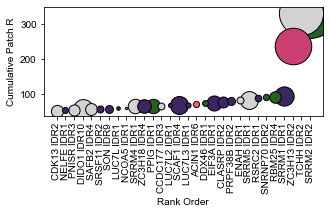

In [11]:
mygeneralcolors={'Major Spliceosome':'#276026', 'Other splicing factors1':'#3d2663', 'RNA Modification':'#cb3f73', 'Minor Spliceosome':'#872f74', 'ASAP complex1':'#ff6361'}

plt.figure(figsize=(5,2))

tmp = np.argsort(topidrslen)
sort_index2 = tmp[::-1] 

for s in sort_index2:
    if topidrsuni[s] in ccacc:
        myidx=ccacc.index(topidrsuni[s])
        mycurrcolor=mygeneralcolors[ccgeneralprocess[myidx]]
        plt.plot(topnum-s+1,topidrsval[s],'o',markersize=(topidrslen[s])/40,markerfacecolor=mycurrcolor,markeredgecolor='black')
    else:
        plt.plot(topnum-s+1,topidrsval[s],'o',markersize=(topidrslen[s])/40,markerfacecolor='lightgrey',markeredgecolor='black')
    
plt.xticks(np.arange(len(topidrsgene)+1,1,-1),topidrsgene,rotation=90)

plt.ylabel(sortbyval)
plt.xlabel('Rank Order')

#plt.savefig('Figures/2024_02/top_idrs_sorted_all_locations/All_sapien_IDRs_feature_'+sortbyval+'_w_process_reversed.pdf', transparent=True, bbox_inches = "tight") 


## 1.10 - Get number in top 80 for each process

In [33]:
sortbyval=['Cumulative Patch R','pos-neg']
#sortbyval=['R Patch','pos-neg']
topnum=80 #30 for plotting, 80 for visualization

topgenesbytype=[[] for _ in range(len(sortbyval))]
topunibytype=[[] for _ in range(len(sortbyval))]
for v in range(0,len(sortbyval)):
    print(sortbyval[v])
    dfrichsorted = dfrich.sort_values(by=sortbyval[v], ascending=False)


    topidrsval=dfrichsorted[sortbyval[v]].tolist()[:topnum]
    topidrsgene=dfrichsorted['Gene'].tolist()[:topnum]
    topidrsuni=dfrichsorted['Uniprot'].tolist()[:topnum]
    topidrslen=dfrichsorted['IDR Length'].tolist()[:topnum]
    
    #print(dfrichsorted[['Gene',sortbyval[v]]].head(topnum))
    
    for i in range(0,len(topidrsgene)):
        topgenesbytype[v].append(topidrsgene[i])
        topunibytype[v].append(topidrsuni[i])

    #pos=[i for i, x in enumerate(ccgeneralprocess) if x=='Major Spliceosome']
    pos=[i for i, x in enumerate(cccategory) if x=='Spliceosomal A complex']
    #pos=[i for i, x in enumerate(cccategory) if x=='Serine and arginine rich splicing factors']

    for p in pos:
        curracc=ccacc[p]
        if curracc in topidrsuni:
            myidx=topidrsuni.index(curracc)
            print(topidrsgene[myidx]+': '+str(myidx+1))
            
print(len(topgenesbytype[0]))

Cumulative Patch R
CCAR1 IDR2: 71
DDX46 IDR1: 13
U2AF1 IDR1: 80
RBM25 IDR4: 5
pos-neg
80


## 1.11 - Plot number of top 80 IDRs in spliceosome processes

Serine and arginine rich splicing factors
12
Cumulative Patch R
SRSF2 IDR1: 32
Cumulative Patch R
SRSF4 IDR1: 38
Cumulative Patch R
SRSF5 IDR2: 42
Cumulative Patch R
SRSF6 IDR2: 50
Cumulative Patch R
SRSF7 IDR1: 58
Cumulative Patch R
SRSF8 IDR1: 47
Cumulative Patch R
SRSF11 IDR2: 25
[7. 0. 5.]
12.0=12
U1 small nuclear ribonucleoprotein
3
Cumulative Patch R
SNRNP70 IDR2: 6
[1. 0. 2.]
3.0=3
Sm spliceosomal proteins
8
[0. 0. 8.]
8.0=8
Spliceosomal E complex
4
Cumulative Patch R
U2AF1 IDR1: 80
[1. 0. 3.]
4.0=4
U2 small nuclear ribonucleoprotein
5
[0. 0. 5.]
5.0=5
SF3a complex
3
[0. 0. 3.]
3.0=3
SF3b complex
7
[0. 0. 7.]
7.0=7
Spliceosomal A complex
19
Cumulative Patch R
CCAR1 IDR2: 71
Cumulative Patch R
DDX46 IDR1: 13
Cumulative Patch R
U2AF1 IDR1: 80
Cumulative Patch R
RBM25 IDR4: 5
[ 4.  0. 15.]
19.0=19
tri-snRP complex
4
Cumulative Patch R
SNRNP27 IDR1: 36
[1. 0. 3.]
4.0=4
U5 small nuclear ribonucleoprotein
8
Cumulative Patch R
DDX23 IDR1: 64
pos-neg
CD2BP2 IDR1: 56
[1. 1. 6.]
8.0=8
U4/

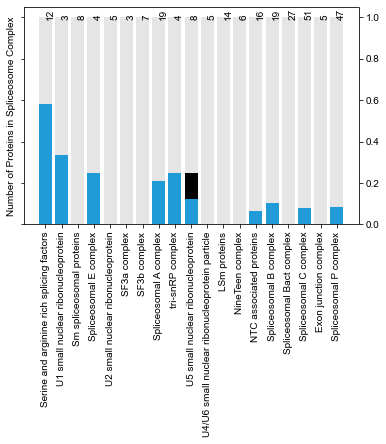

In [34]:
## Right now this looks at each protein as one so if had two idrs that each had a top feature would only pick the top IDR
mysorteduniccgeneralprocess=['Serine and arginine rich splicing factors','U1 small nuclear ribonucleoprotein','Sm spliceosomal proteins','Spliceosomal E complex','U2 small nuclear ribonucleoprotein','SF3a complex','SF3b complex','Spliceosomal A complex','tri-snRP complex', 'U5 small nuclear ribonucleoprotein','U4/U6 small nuclear ribonucleoprotein particle', 'LSm proteins', 'NineTeen complex', 'NTC associated proteins', 'Spliceosomal B complex', 'Spliceosomal Bact complex','Spliceosomal C complex','Exon junction complex','Spliceosomal P complex']
#mysorteduniccgeneralprocess=unicccategory


#['ASAP complex', 'U11/U12 di-snRNP', 'WTAP complex', 'm6A methyltransferase complex', 'Other pre-mRNA splicing factors']

f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position('both')

count0=[]
count1=[]
count2=[]
for s in range(0,len(mysorteduniccgeneralprocess)):
    count=np.zeros((len(sortbyval)+1))
    print(mysorteduniccgeneralprocess[s])
    pos=[i for i, x in enumerate(cccategory) if x==mysorteduniccgeneralprocess[s]]
    print(len(pos))

    for p in pos:
        curracc=ccacc[p]
        tmpidx=[100, 100, 100]
        for v in range(0,len(sortbyval)):
            if curracc in topunibytype[v]:
                tmpidx[v]=topunibytype[v].index(curracc)
                print(sortbyval[v])
                print(topgenesbytype[v][tmpidx[v]]+': '+str(tmpidx[v]+1))
        minidx=tmpidx.index(min(tmpidx))
        if tmpidx[minidx]==100:
            count[len(sortbyval)]=count[len(sortbyval)]+1
        else:
            count[minidx]=count[minidx]+1

    print(count)
    count0.append(count[0])
    count1.append(count[1])
    count2.append(count[2])
    print(str(sum(count))+'='+str(len(pos)))
    count=count/sum(count)

    plt.bar(s, count[0], color='#209bd7')
    plt.bar(s, count[1], bottom=count[0], color='#000000')
    plt.bar(s, count[2], bottom=count[0]+count[1], color='#e5e5e5')
    plt.text(s,sum(count),len(pos),rotation=90)
    
plt.xticks(np.arange(0,len(mysorteduniccgeneralprocess),1),mysorteduniccgeneralprocess,rotation=90)
plt.ylabel('Fraction of Proteins in Spliceosome Complex')
#plt.savefig('Figures/2024_02/top_idrs_sorted_all_locations/All_sapien_IDRs_feature_'+sortbyval[0]+'_'+sortbyval[1]+'_fraction_exceptional_by_major_spliceosome_complex.pdf', transparent=True, bbox_inches = "tight") 

plt.ylabel('Number of Proteins in Spliceosome Complex')
#plt.savefig('Figures/2024_02/top_idrs_sorted_all_locations/All_sapien_IDRs_feature_'+sortbyval[0]+'_'+sortbyval[1]+'_number_exceptional_by_major_spliceosome_complex.pdf', transparent=True, bbox_inches = "tight") 

tmpdf=pd.DataFrame()
tmpdf['Process']=mysorteduniccgeneralprocess
tmpdf[sortbyval[0]]=count0
tmpdf[sortbyval[1]]=count1
tmpdf['None']=count2

print(tmpdf)
#with pd.ExcelWriter('../Supplementary_Tables/Table_S3.xlsx', engine='openpyxl',mode='a') as writer:
#    tmpdf.to_excel(writer,sheet_name='aFig_S3F')

## 1.12 - Save data to excel file

In [32]:
sortbyval=['Cumulative Patch R','pos-neg']
topnum=80 #30 for plotting, 80 for visualization

accsbyproc=[[] for _ in range(len(uniccgeneralprocess))]
for s in range(0,len(uniccgeneralprocess)):
    #print(mysorteduniccgeneralprocess[s])
    pos=[i for i, x in enumerate(ccgeneralprocess) if x==uniccgeneralprocess[s]]
    for p in pos:
        accsbyproc[s].append(ccacc[p])

topgenesbytype=[[] for _ in range(len(sortbyval))]
topunibytype=[[] for _ in range(len(sortbyval))]
for v in range(0,len(sortbyval)):
    print(sortbyval[v])
    dfrichsorted = dfrich.sort_values(by=sortbyval[v], ascending=False)


    topidrsval=dfrichsorted[sortbyval[v]].tolist()[:topnum]
    topidrsgene=dfrichsorted['Gene'].tolist()[:topnum]
    topidrsuni=dfrichsorted['Uniprot'].tolist()[:topnum]
    topidrslen=dfrichsorted['IDR Length'].tolist()[:topnum]
    
    topidrproc=[]
    for i in range(0,len(topidrsuni)):
        whichproc=[]
        for s in range(0,len(uniccgeneralprocess)):
            if topidrsuni[i] in accsbyproc[s]:
                whichproc.append(uniccgeneralprocess[s])
                
        if len(whichproc)==1:
            topidrproc.append(whichproc[0])
        elif len(whichproc)>1:
            topidrproc.append(', '.join(whichproc))
        else:
            topidrproc.append('')
    

    topidrsdf=pd.DataFrame()
    topidrsdf['Uniprot']=topidrsuni
    topidrsdf['Gene']=topidrsgene
    topidrsdf['IDR Length']=topidrslen
    topidrsdf[sortbyval[v]]=topidrsval
    topidrsdf['Process']=topidrproc
    print(topidrsdf.head(30))

    #with pd.ExcelWriter('../Supplementary_Tables/Table_S3.xlsx', engine='openpyxl',mode='a') as writer:
    #    topidrsdf.to_excel(writer,sheet_name='top_'+str(topnum)+'_'+sortbyval[v])


Cumulative Patch R
   Uniprot          Gene  IDR Length  Cumulative Patch R  \
0   Q9UQ35    SRRM2 IDR2        2077                 334   
1   Q07283     TCHH IDR2        1768                 330   
2   Q5T200   ZC3H13 IDR2        1461                 236   
3   Q8IYB3    SRRM1 IDR1         771                  95   
4   P49756    RBM25 IDR4         464                  94   
5   P08621  SNRNP70 IDR2         252                  92   
6   Q7L4I2    RSRC2 IDR1         264                  90   
7   B3KS81    SRRM5 IDR1         715                  84   
8   Q8N8S7     ENAH IDR1         279                  83   
9   Q5VTL8  PRPF38B IDR2         319                  81   
10  Q8N2M8   CLASRP IDR2         440                  80   
11  Q14152    EIF3A IDR1         602                  77   
12  Q7L014    DDX46 IDR1         234                  75   
13  Q9UKV3    ACIN1 IDR6         245                  73   
14  O95232   LUC7L3 IDR1         205                  71   
15  Q9H7N4    SCAF1 I